In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
%matplotlib inline

In [14]:
transformation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307, ), (0.3081, ))
    ]
)

In [15]:
train_dataset = torchvision.datasets.MNIST('data/', train=True, download=True, transform=transformation)
test_dataset = torchvision.datasets.MNIST('data/', train=False, download=True, transform=transformation)

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [17]:
train_loader_iter = train_loader.__iter__()

In [8]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image, cmap='gray')

In [18]:
sample_data = train_loader_iter.__next__()

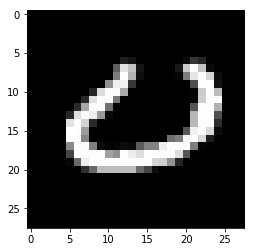

In [22]:
plot_img(sample_data[0][1])

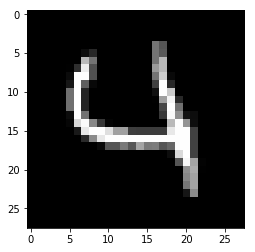

In [23]:
plot_img(sample_data[0][2])

In [24]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)